In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 6.6 MB/s 


<h1>Importing the modules</h1>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg_preprocess
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input as mobile_preprocess
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input as res_preprocess
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input as dense_preprocess
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as xception_preprocess
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
import os
from zipfile import ZipFile as zipfile
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil as sh
import time
from google.colab import drive
from collections import defaultdict
import tensorflow_addons as tfa

<h1>For Loading dataset</h1>

In [ ]:
# # Mounting Google Drive
# print("[INFO] Connecting to Google Drive")
# drive.mount('/content/drive')
# print("Done!")

MAIN_PATH=os.path.join("drive","MyDrive","Global Smoke Detection")
#For Extracting the Dataset
# specifying the zip file path
ZIP_PATH=os.path.join(MAIN_PATH,"Dataset.zip")

# opening the zip file in READ mode
with zipfile(ZIP_PATH, 'r') as fin:
	# printing all the contents of the zip file
	#zip.printdir()

	#extracting all the files
	print('[INFO]Extracting all the files now...')
	fin.extractall()
	print('Done!')

# Creating paths for generators
print("\n[INFO]Creating Paths for Train, Validation and Test directories...")
TRAIN_DIR=os.path.join("Dataset","Images","train")
VALID_DIR=os.path.join("Dataset","Images","valid")
TEST_DIR=os.path.join("Dataset","Images","test")
print("Done!")

[INFO]Extracting all the files now...
Done!

[INFO]Creating Paths for Train, Validation and Test directories...
Done!


<h1>My Utils</h1>

In [ ]:
def get_generators(TRAIN_DIR: str, VALID_DIR: str, TEST_DIR: str, target_size: tuple = (224, 224)) -> tuple:
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       rotation_range=40,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       zoom_range=0.2,
                                       height_shift_range=0.1,
                                       width_shift_range=0.1,
                                       fill_mode="nearest")

    valid_datagen = ImageDataGenerator(rescale=1. / 255)

    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                        target_size=target_size,
                                                        color_mode="rgb",
                                                        class_mode="categorical")

    valid_generator = valid_datagen.flow_from_directory(VALID_DIR,
                                                        target_size=target_size,
                                                        color_mode="rgb",
                                                        class_mode="categorical")

    test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                      target_size=target_size,
                                                      color_mode="rgb",
                                                      class_mode="categorical")

    return train_generator, valid_generator, test_generator

def plot_history(history):
    info = pd.DataFrame(history.history)
    info["f1_score"]=info["f1_score"].map(lambda x: (x[0]+x[1])/2)
    info["val_f1_score"]=info["val_f1_score"].map(lambda x: (x[0]+x[1])/2)

    plt.figure(figsize=(20,15))
    plt.subplots_adjust(hspace=0.3,wspace=0.3)
    
    plt.subplot(321)
    plt.plot(info["loss"], label="Training loss")
    plt.plot(info["val_loss"], label="Validation loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(322)
    plt.plot(info["categorical_accuracy"], label="Training accuracy")
    plt.plot(info["val_categorical_accuracy"], label="Validation accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(323)
    plt.plot(info["precision"], label="Precision")
    plt.plot(info["val_precision"], label="Validation Precision")
    # plt.plot(info["recall"], label="Recall")
    # plt.plot(info["val_recall"], label="Validation Recall")
    plt.title("Precision")
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend()

    plt.subplot(324)
    plt.plot(info["recall"], label="Recall")
    plt.plot(info["val_recall"], label="Validation Recall")
    plt.title("Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.legend()

    plt.subplot(325)
    plt.plot(info["f1_score"], label="F1-Score")
    plt.plot(info["val_f1_score"], label="Validation F1-Score")
    plt.title("F1-Score")
    plt.xlabel("Epochs")
    plt.ylabel("F1-Score")
    plt.legend()
    

    plt.show()

train_generator,valid_generator,test_generator=get_generators(TRAIN_DIR,VALID_DIR,TEST_DIR,target_size=(224,224))

Found 10712 images belonging to 2 classes.
Found 10617 images belonging to 2 classes.
Found 2888 images belonging to 2 classes.


<h1>Utils for Shubham Model</h1>

In [ ]:
def get_gaussian_kernel(shape, sigma=0.5):
    """build the gaussain filter"""
    m, n = [(ss - 1.) / 2. for ss in shape]
    x = tf.expand_dims(tf.range(-n, n + 1, dtype=tf.float32), 1)
    y = tf.expand_dims(tf.range(-m, m + 1, dtype=tf.float32), 0)
    h = tf.exp(tf.math.divide_no_nan(-((x * x) + (y * y)), 2 * sigma * sigma))
    h = tf.math.divide_no_nan(h, tf.reduce_sum(h))
    return h


def gaussian_blur(inp, shape, sigma=0.5):
    """Convolve using tf.nn.depthwise_conv2d"""
    in_channel = tf.shape(inp)[-1]
    k = get_gaussian_kernel(shape, sigma)
    k = tf.expand_dims(k, axis=-1)
    k = tf.repeat(k, in_channel, axis=-1)
    k = tf.reshape(k, (*shape, in_channel, 1))
    # using padding same to preserve size (H,W) of the input
    conv = tf.nn.depthwise_conv2d(inp, k, strides=[1, 1, 1, 1], padding="SAME")
    return conv


def cbam_block(encoder_layer, decoder_layer, ratio=4):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """

    cbam_feature = channel_attention(encoder_layer, decoder_layer, ratio)
    cbam_feature = spatial_attention(encoder_layer, decoder_layer)
    return cbam_feature


def channel_attention(encoder_layer, decoder_layer, ratio=4):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = encoder_layer.shape[channel_axis]

    shared_layer_one = tf.keras.layers.Dense(channel // ratio,
                                             activation='relu',
                                             kernel_initializer='he_normal',
                                             use_bias=True,
                                             bias_initializer='zeros')
    shared_layer_two = tf.keras.layers.Dense(channel,
                                             kernel_initializer='he_normal',
                                             use_bias=True,
                                             bias_initializer='zeros')

    avg_pool = tf.keras.layers.GlobalAveragePooling2D()(encoder_layer)
    avg_pool = tf.keras.layers.Reshape((1, 1, channel))(avg_pool)
    assert avg_pool.shape[1:] == (1, 1, channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1, 1, channel // ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1, 1, channel)

    max_pool = tf.keras.layers.GlobalMaxPooling2D()(encoder_layer)
    max_pool = tf.keras.layers.Reshape((1, 1, channel))(max_pool)
    assert max_pool.shape[1:] == (1, 1, channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1, 1, channel // ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1, 1, channel)

    cbam_feature = tf.keras.layers.Add()([avg_pool, max_pool])
    cbam_feature = tf.keras.layers.Conv2D(filters=1,
                                          kernel_size=1,
                                          strides=1,
                                          padding='same',
                                          activation='relu',
                                          kernel_initializer='he_normal',
                                          use_bias=False)(cbam_feature)
    cbam_feature = tf.keras.layers.Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = tf.keras.layers.Permute((3, 1, 2))(cbam_feature)

    return tf.keras.layers.multiply([decoder_layer, cbam_feature])


def spatial_attention(encoder_layer, decoder_layer):
    kernel_size = 3

    if K.image_data_format() == "channels_first":
        channel = encoder_layer.shape[1]
        cbam_feature = tf.keras.layers.Permute((2,3,1))(encoder_layer)
    else:
        channel = encoder_layer.shape[-1]
        cbam_feature = encoder_layer

    avg_pool = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = tf.keras.layers.Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = tf.keras.layers.Conv2D(filters = 1,
                                          kernel_size=kernel_size,
                                          strides=1,
                                          padding='same',
                                          activation='relu',
                                          kernel_initializer='he_normal',
                                          use_bias=False)(concat)
    cbam_feature = tf.keras.layers.Activation('sigmoid')(cbam_feature)
    assert cbam_feature.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = tf.keras.layers.Permute((3, 1, 2))(cbam_feature)

    return tf.keras.layers.multiply([decoder_layer, cbam_feature])


class Wt_Add(keras.layers.Layer):
    def __init__(self, units=1, input_dim=1):
        super(Wt_Add, self).__init__()
        w_init = tf.random_normal_initializer()
        self.w1 = tf.Variable(
            initial_value=w_init(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )
        self.w2 = tf.Variable(
            initial_value=w_init(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )
        self.w3 = tf.Variable(
            initial_value=w_init(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, input1, input2, input3):
        return tf.multiply(input1, self.w1) + tf.multiply(input2, self.w2) + tf.multiply(input3, self.w3)

<h1>Main Function for Two Path Models</h1>

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images, **kwargs):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch, **kwargs):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


class TwoPathModel:

    @staticmethod
    def mlp(x, hidden_units, dropout_rate):
        for units in hidden_units:
            x = layers.Dense(units, activation=tf.nn.gelu)(x)
            x = layers.Dropout(dropout_rate)(x)
        return x

    @staticmethod
    def create_transformer_head(input_shape=(224, 224, 3),
                                image_size=72,  # We'll resize input images to this size
                                patch_size=6,  # Size of the patches to be extract from the input images
                                num_patches=(72 // 6) ** 2,
                                projection_dim=64,
                                num_heads=4,
                                transformer_units=(128, 64),  # Size of the transformer layers
                                transformer_layers=8):
        inputs = layers.Input(shape=input_shape)
        # # Augment data.
        # augmented = data_augmentation(inputs)
        # done through ImageDataGenerator
        resized_inputs = keras.layers.Resizing(image_size, image_size)(inputs)
        # Create patches.
        patches = Patches(patch_size)(resized_inputs)
        # Encode patches.
        encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

        # Create multiple layers of the Transformer block.
        for _ in range(transformer_layers):
            # Layer normalization 1.
            x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
            # Create a multi-head attention layer.
            attention_output = layers.MultiHeadAttention(
                num_heads=num_heads, key_dim=projection_dim, dropout=0.1
            )(x1, x1)
            # Skip connection 1.
            x2 = layers.Add()([attention_output, encoded_patches])
            # Layer normalization 2.
            x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
            # MLP.
            x3 = TwoPathModel.mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
            # Skip connection 2.
            encoded_patches = layers.Add()([x3, x2])

        # Create a [batch_size, projection_dim] tensor.
        representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        representation = layers.GlobalAveragePooling1D()(representation)
        representation = layers.Dropout(0.1)(representation)
        # Add MLP.
        # features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
        representation = layers.Dense(256, activation=tf.nn.gelu, kernel_initializer="he_normal")(representation)
        representation = layers.Dropout(0.5)(representation)
        model = keras.Model(inputs=inputs, outputs=representation)

        return model

    @staticmethod
    def create_vgg_head(input_shape=(224, 224, 3)):
        vgg = VGG16(include_top=False, weights=None, input_shape=input_shape)
        representation = keras.layers.GlobalAveragePooling2D()(vgg.output)
        representation = keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal")(representation)
        model = keras.models.Model(inputs=vgg.input, outputs=representation)

        return model

    @staticmethod
    def create_mobilenet_head(input_shape=(224, 224, 3)):
        mobilenet = MobileNetV2(input_shape=input_shape, include_top=False, weights=None)
        representation = keras.layers.GlobalAveragePooling2D()(mobilenet.output)
        representation = keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal")(representation)
        model = keras.models.Model(inputs=mobilenet.input, outputs=representation)

        return model

    @staticmethod
    def create_densenet121_head(input_shape=(224, 224, 3)):
        densenet121 = DenseNet121(include_top=False, weights=None, input_shape=input_shape)
        representation = keras.layers.GlobalAveragePooling2D()(densenet121.output)
        representation = keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal")(representation)
        model = keras.models.Model(inputs=densenet121.input, outputs=representation)

        return model

    @staticmethod
    def create_resnet50_head(input_shape=(224, 224, 3)):
        resnet50 = ResNet50(include_top=False, weights=None, input_shape=input_shape)
        representation = keras.layers.GlobalAveragePooling2D()(resnet50.output)
        representation = keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal")(representation)
        model = keras.models.Model(inputs=resnet50.input, outputs=representation)

        return model

    @staticmethod
    def create_xception_head(input_shape=(224, 224, 3)):
        xception = Xception(include_top=False, weights=None, input_shape=input_shape)
        representation = keras.layers.GlobalAveragePooling2D()(xception.output)
        representation = keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal")(representation)
        model = keras.models.Model(inputs=xception.input, outputs=representation)

        return model

    @staticmethod
    def create_shubham_head(input_shape=(224, 224, 3), alpha=0.05, reg=0.001):
        inputs = tf.keras.Input(input_shape)
        x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
        x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid')(x)

        x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
        x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)

        x = x + spatial_attention(x, x)
        x = x + channel_attention(x, x)

        x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid')(x)

        x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
        x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
        x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
        x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid')(x)
        x3 = x

        x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
        x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
        x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
        x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid')(x)
        x4 = x

        x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
        x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
        x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
        x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid')(x)
        x5 = x

        x3 = tf.keras.layers.Conv2D(256, 1, padding='same', activation='relu')(x3)
        x4 = tf.keras.layers.Conv2D(256, 1, padding='same', activation='relu')(x4)
        x5 = tf.keras.layers.Conv2D(256, 1, padding='same', activation='relu')(x5)
        xp = x5

        xq = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x5)
        xq = xq + x4
        xr = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(xq)
        xr = xr + x3

        # xps=x=tf.keras.layers.Conv2D(256,3,padding='same',activation='relu')(xp)
        xps = gaussian_blur(xp, xp.shape[1:-1])
        xps = x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(xps)
        xps = tf.keras.layers.Dropout(0.5)(xps)
        xps = tf.keras.layers.GlobalMaxPool2D()(xps)
        # xps=tf.keras.layers.Dense(256,kernel_initializer=tf.constant_initializer(1.))(xps)

        # xqs=x=tf.keras.layers.Conv2D(256,3,padding='same',activation='relu')(xq)
        xqs = gaussian_blur(xq, xq.shape[1:-1])
        xqs = x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(xqs)
        xqs = tf.keras.layers.Dropout(0.5)(xqs)
        xqs = tf.keras.layers.GlobalMaxPool2D()(xqs)
        # xqs=tf.keras.layers.Dense(256,kernel_initializer=tf.constant_initializer(1.))(xqs)

        # xrs=x=tf.keras.layers.Conv2D(256,3,padding='same',activation='relu')(xr)
        xrs = gaussian_blur(xr, xr.shape[1:-1])
        xrs = x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(xr)
        xrs = tf.keras.layers.Dropout(0.5)(xrs)
        xrs = tf.keras.layers.GlobalMaxPool2D()(xrs)
        # xrs=tf.keras.layers.Dense(256,kernel_initializer=tf.constant_initializer(1.))(xrs)

        # xf=xps+xqs+xrs
        # xf1=xp+xq+xr
        wt_add = Wt_Add(1, 1)
        xf = wt_add(xps, xrs, xqs)

        # x=tf.keras.layers.Flatten()(xr)
        # x=tf.keras.layers.Dropout(0.5)(x)
        # x = tf.keras.layers.Dense(output_size, activation="softmax")(xf)

        model = tf.keras.Model(inputs=inputs, outputs=xf)

        return model

    @staticmethod
    def two_path_vgg(input_shape=(224, 224, 3), mix_type: str = "add", preprocess_fn=vgg_preprocess):
        if mix_type == "add":
            mix_layer = keras.layers.Add()
        else:
            mix_layer = keras.layers.Concatenate()
        inputs = layers.Input(shape=input_shape)

        transformer_head = TwoPathModel.create_transformer_head(input_shape=input_shape)
        transformer_outputs = transformer_head(inputs)

        vgg_head = TwoPathModel.create_vgg_head(input_shape=input_shape)
        processed_inputs = preprocess_fn(inputs)
        vgg_outputs = vgg_head(processed_inputs)

        mix = mix_layer([transformer_outputs, vgg_outputs])
        final_dense = keras.layers.Dense(128, activation=tf.nn.gelu, kernel_initializer="he_normal")(mix)
        final_dropout = keras.layers.Dropout(0.5)(final_dense)

        outputs = keras.layers.Dense(2, activation="softmax")(final_dropout)
        model = keras.models.Model(inputs=inputs, outputs=outputs)

        return model

    @staticmethod
    def two_path_mobilenet(input_shape=(224, 224, 3), mix_type: str = "add", preprocess_fn=mobile_preprocess):
        if mix_type == "add":
            mix_layer = keras.layers.Add()
        else:
            mix_layer = keras.layers.Concatenate()
        inputs = layers.Input(shape=input_shape)

        transformer_head = TwoPathModel.create_transformer_head(input_shape=input_shape)
        transformer_outputs = transformer_head(inputs)

        mobile_head = TwoPathModel.create_mobilenet_head(input_shape=input_shape)
        processed_inputs = preprocess_fn(inputs)
        mobile_outputs = mobile_head(processed_inputs)

        mix = mix_layer([transformer_outputs, mobile_outputs])
        final_dense = keras.layers.Dense(128, activation=tf.nn.gelu, kernel_initializer="he_normal")(mix)
        final_dropout = keras.layers.Dropout(0.5)(final_dense)

        outputs = keras.layers.Dense(2, activation="softmax")(final_dropout)
        model = keras.models.Model(inputs=inputs, outputs=outputs)

        return model

    @staticmethod
    def two_path_densenet121(input_shape=(224, 224, 3), mix_type: str = "add", preprocess_fn=dense_preprocess):
        if mix_type == "add":
            mix_layer = keras.layers.Add()
        else:
            mix_layer = keras.layers.Concatenate()
        inputs = layers.Input(shape=input_shape)

        transformer_head = TwoPathModel.create_transformer_head(input_shape=input_shape)
        transformer_outputs = transformer_head(inputs)

        dense_head = TwoPathModel.create_densenet121_head(input_shape=input_shape)
        processed_inputs = preprocess_fn(inputs)
        dense_outputs = dense_head(processed_inputs)

        mix = mix_layer([transformer_outputs, dense_outputs])
        final_dense = keras.layers.Dense(128, activation=tf.nn.gelu, kernel_initializer="he_normal")(mix)
        final_dropout = keras.layers.Dropout(0.5)(final_dense)

        outputs = keras.layers.Dense(2, activation="softmax")(final_dropout)
        model = keras.models.Model(inputs=inputs, outputs=outputs)

        return model

    @staticmethod
    def two_path_resnet(input_shape=(224, 224, 3), mix_type: str = "add", preprocess_fn=res_preprocess):
        if mix_type == "add":
            mix_layer = keras.layers.Add()
        else:
            mix_layer = keras.layers.Concatenate()
        inputs = layers.Input(shape=input_shape)

        transformer_head = TwoPathModel.create_transformer_head(input_shape=input_shape)
        transformer_outputs = transformer_head(inputs)

        resnet_head = TwoPathModel.create_resnet50_head(input_shape=input_shape)
        processed_inputs = preprocess_fn(inputs)
        resnet_outputs = resnet_head(processed_inputs)

        mix = mix_layer([transformer_outputs, resnet_outputs])
        final_dense = keras.layers.Dense(128, activation=tf.nn.gelu, kernel_initializer="he_normal")(mix)
        final_dropout = keras.layers.Dropout(0.5)(final_dense)

        outputs = keras.layers.Dense(2, activation="softmax")(final_dropout)
        model = keras.models.Model(inputs=inputs, outputs=outputs)

        return model

    @staticmethod
    def two_path_xception(input_shape=(224, 224, 3), mix_type: str = "add", preprocess_fn=xception_preprocess):
        if mix_type == "add":
            mix_layer = keras.layers.Add()
        else:
            mix_layer = keras.layers.Concatenate()
        inputs = layers.Input(shape=input_shape)
        transformer_head = TwoPathModel.create_transformer_head(input_shape=input_shape)
        transformer_outputs = transformer_head(inputs)

        xception_head = TwoPathModel.create_xception_head(input_shape=input_shape)
        processed_inputs = preprocess_fn(inputs)
        xception_outputs = xception_head(processed_inputs)

        mix = mix_layer([transformer_outputs, xception_outputs])
        final_dense = keras.layers.Dense(128, activation=tf.nn.gelu, kernel_initializer="he_normal")(mix)
        final_dropout = keras.layers.Dropout(0.5)(final_dense)

        outputs = keras.layers.Dense(2, activation="softmax")(final_dropout)
        model = keras.models.Model(inputs=inputs, outputs=outputs)

        return model

    @staticmethod
    def two_path_shubham_model(input_shape=(224, 224, 3), mix_type: str = "add"):
        if mix_type == "add":
            mix_layer = keras.layers.Add()
        else:
            mix_layer = keras.layers.Concatenate()
        inputs = layers.Input(shape=input_shape)
        transformer_head = TwoPathModel.create_transformer_head(input_shape=input_shape)
        transformer_outputs = transformer_head(inputs)

        shubham_head = TwoPathModel.create_shubham_head(input_shape=input_shape)
        shubham_outputs = shubham_head(inputs)

        mix = mix_layer([transformer_outputs, shubham_outputs])
        final_dense = keras.layers.Dense(128, activation=tf.nn.gelu, kernel_initializer="he_normal")(mix)
        final_dropout = keras.layers.Dropout(0.5)(final_dense)

        outputs = keras.layers.Dense(2, activation="softmax")(final_dropout)
        model = keras.models.Model(inputs=inputs, outputs=outputs)

        return model


<h1>Making the vgg model</h1>

In [ ]:
vgg_model=TwoPathModel.two_path_vgg(preprocess_fn=vgg_preprocess)

In [ ]:
vgg_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 224, 224, 3)  0          ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.nn.bias_add (TFOpLambda)    (None, 224, 224, 3)  0           ['tf.__operators__.getitem[0][0]'
                                                                 ]                          

<h1>Training the model for 20 epochs at lr=1e-4</h1>

In [ ]:
vgg_model.compile(loss="categorical_crossentropy",
                  optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=[keras.metrics.CategoricalAccuracy(),keras.metrics.Precision(),keras.metrics.Recall(),tfa.metrics.F1Score(num_classes=2)])

In [ ]:
history=vgg_model.fit(train_generator,epochs=20,validation_data=valid_generator)

Epoch 1/20
335/335 [==============================] - 293s 744ms/step - loss: 0.5486 - categorical_accuracy: 0.7653 - precision: 0.7653 - recall: 0.7653 - f1_score: 0.5459 - val_loss: 0.3792 - val_categorical_accuracy: 0.8282 - val_precision: 0.8282 - val_recall: 0.8282 - val_f1_score: 0.6632
Epoch 2/20
335/335 [==============================] - 238s 711ms/step - loss: 0.3854 - categorical_accuracy: 0.8277 - precision: 0.8277 - recall: 0.8277 - f1_score: 0.7025 - val_loss: 0.3484 - val_categorical_accuracy: 0.8558 - val_precision: 0.8558 - val_recall: 0.8558 - val_f1_score: 0.7557
Epoch 3/20
335/335 [==============================] - 238s 710ms/step - loss: 0.3418 - categorical_accuracy: 0.8551 - precision: 0.8551 - recall: 0.8551 - f1_score: 0.7627 - val_loss: 0.3092 - val_categorical_accuracy: 0.8666 - val_precision: 0.8666 - val_recall: 0.8666 - val_f1_score: 0.7918
Epoch 4/20
335/335 [==============================] - 238s 709ms/step - loss: 0.3238 - categorical_accuracy: 0.8609 - 

In [ ]:
vgg_model.save_weights("two_path_vgg.h5")

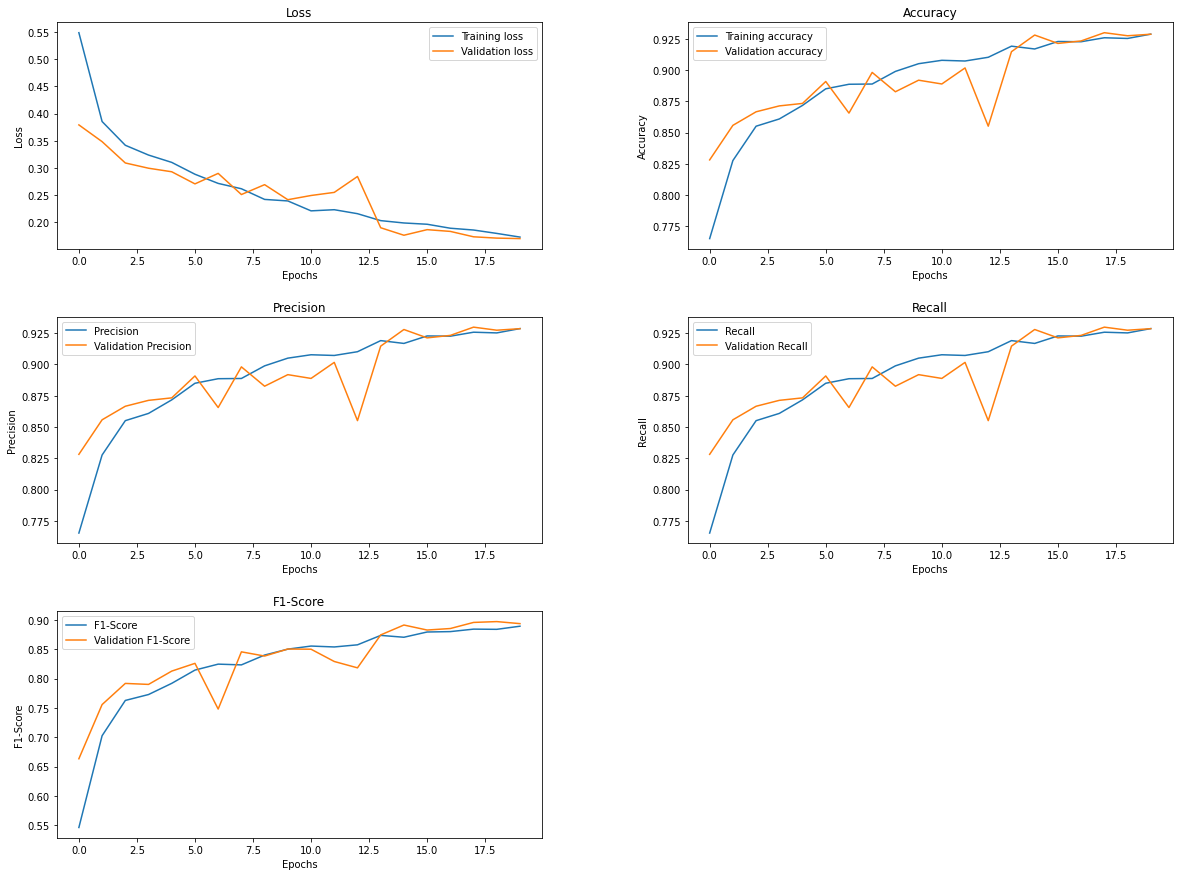

In [ ]:
plot_history(history)

<h1>Making the Mobilenet model</h1>

In [ ]:
mobilenet_model=TwoPathModel.two_path_mobilenet(preprocess_fn=mobile_preprocess)

In [ ]:
mobilenet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 224, 224, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 model_1 (Functional)           (None, 256)          698560      ['input_4[0][0]']          

<h1>Training the model for 20 epochs at lr=1e-4</h1>

In [ ]:
mobilenet_model.compile(loss="categorical_crossentropy",
                  optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=[keras.metrics.CategoricalAccuracy(),keras.metrics.Precision(),keras.metrics.Recall(),tfa.metrics.F1Score(num_classes=2)])

In [ ]:
history=mobilenet_model.fit(train_generator,epochs=20,validation_data=valid_generator)

Epoch 1/20
335/335 [==============================] - 199s 505ms/step - loss: 0.4141 - categorical_accuracy: 0.8257 - precision: 0.8257 - recall: 0.8257 - f1_score: 0.7170 - val_loss: 0.5900 - val_categorical_accuracy: 0.7885 - val_precision: 0.7885 - val_recall: 0.7885 - val_f1_score: 0.5022
Epoch 2/20
335/335 [==============================] - 164s 490ms/step - loss: 0.2996 - categorical_accuracy: 0.8745 - precision: 0.8745 - recall: 0.8745 - f1_score: 0.7996 - val_loss: 0.5120 - val_categorical_accuracy: 0.7867 - val_precision: 0.7867 - val_recall: 0.7867 - val_f1_score: 0.4407
Epoch 3/20
335/335 [==============================] - 165s 492ms/step - loss: 0.2550 - categorical_accuracy: 0.8923 - precision: 0.8923 - recall: 0.8923 - f1_score: 0.8312 - val_loss: 0.6182 - val_categorical_accuracy: 0.7688 - val_precision: 0.7688 - val_recall: 0.7688 - val_f1_score: 0.6788
Epoch 4/20
335/335 [==============================] - 165s 492ms/step - loss: 0.2304 - categorical_accuracy: 0.9036 - 

In [ ]:
mobilenet_model.save_weights("two_path_mobilenet.h5")

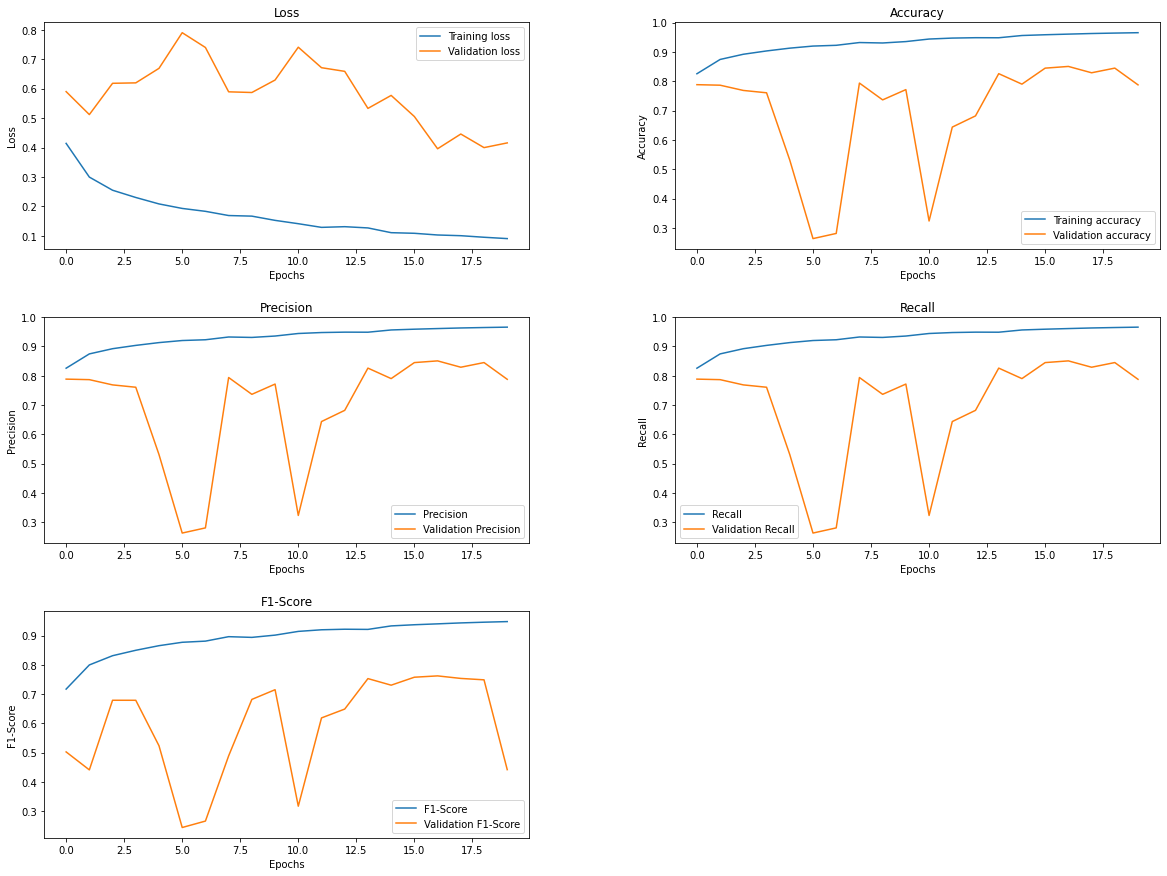

In [ ]:
plot_history(history)

<h1>Making the Densenet model</h1>

In [ ]:
densenet_model=TwoPathModel.two_path_densenet121(preprocess_fn=dense_preprocess)

In [ ]:
densenet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.nn.bias_add (TFOpLambda)    (None, 224, 224, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 tf.math.truediv_1 (TFOpLambda)  (None, 224, 224, 3)  0          ['tf.nn.bias_add[0][0]']   

<h1>Training the model for 20 epochs at lr=1e-4</h1>

In [ ]:
densenet_model.compile(loss="categorical_crossentropy",
                  optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=[keras.metrics.CategoricalAccuracy(),keras.metrics.Precision(),keras.metrics.Recall(),tfa.metrics.F1Score(num_classes=2)])

In [ ]:
history=densenet_model.fit(train_generator,epochs=20,validation_data=valid_generator)

Epoch 1/20
335/335 [==============================] - 277s 702ms/step - loss: 0.4394 - categorical_accuracy: 0.8003 - precision: 0.8003 - recall: 0.8003 - f1_score: 0.6674 - val_loss: 1.8725 - val_categorical_accuracy: 0.7877 - val_precision: 0.7877 - val_recall: 0.7877 - val_f1_score: 0.4406
Epoch 2/20
335/335 [==============================] - 225s 672ms/step - loss: 0.3199 - categorical_accuracy: 0.8541 - precision: 0.8541 - recall: 0.8541 - f1_score: 0.7715 - val_loss: 2.7504 - val_categorical_accuracy: 0.7877 - val_precision: 0.7877 - val_recall: 0.7877 - val_f1_score: 0.4406
Epoch 3/20
335/335 [==============================] - 221s 660ms/step - loss: 0.3034 - categorical_accuracy: 0.8629 - precision: 0.8629 - recall: 0.8629 - f1_score: 0.7863 - val_loss: 2.5869 - val_categorical_accuracy: 0.7877 - val_precision: 0.7877 - val_recall: 0.7877 - val_f1_score: 0.4406
Epoch 4/20
335/335 [==============================] - 222s 663ms/step - loss: 0.2935 - categorical_accuracy: 0.8676 - 

In [ ]:
densenet_model.save_weights("two_path_densenet.h5")

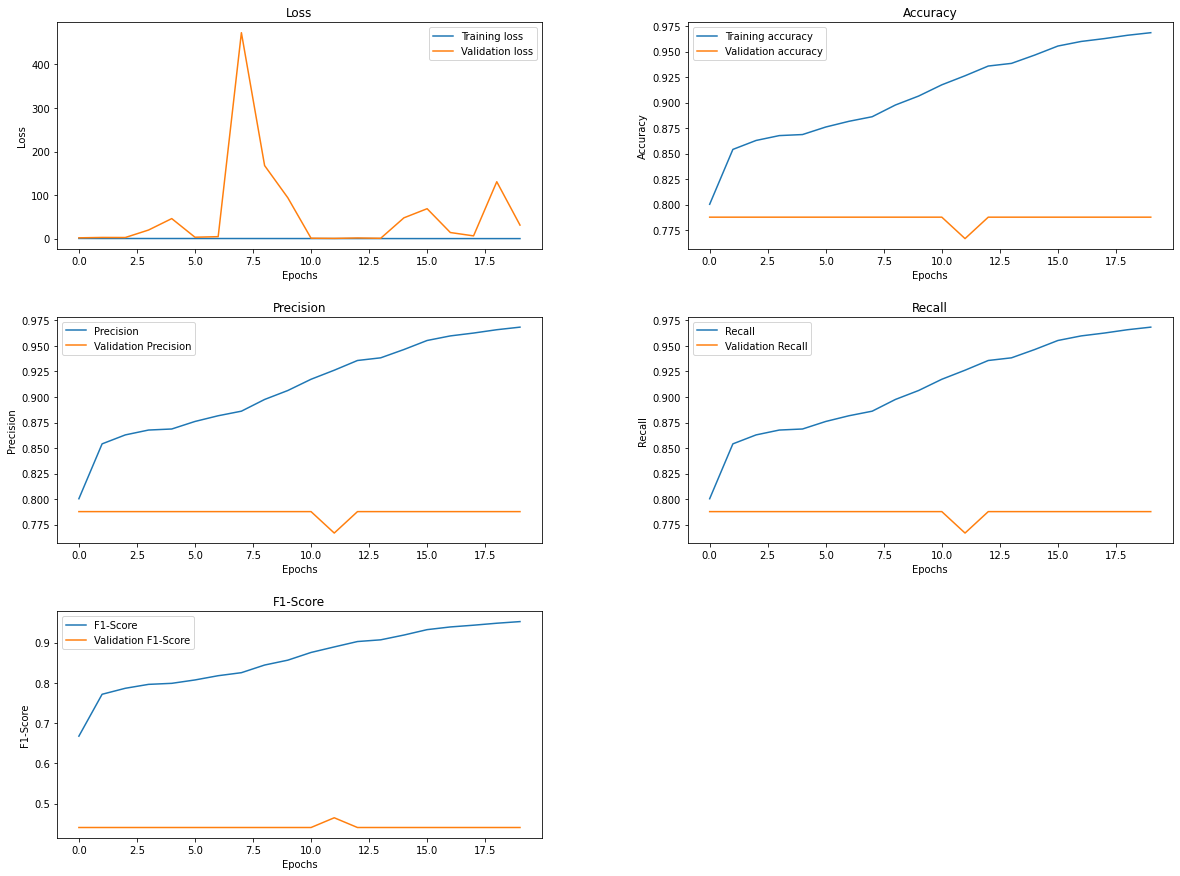

In [ ]:
plot_history(history)

<h1>Making the Resnet model</h1>

In [ ]:
resnet_model=TwoPathModel.two_path_resnet(preprocess_fn=res_preprocess)

In [ ]:
resnet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 224, 224, 3)  0          ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.nn.bias_add (TFOpLambda)    (None, 224, 224, 3)  0           ['tf.__operators__.getitem[0][0]'
                                                                 ]                          

<h1>Training the model for 20 epochs at lr=1e-4</h1>

In [ ]:
resnet_model.compile(loss="categorical_crossentropy",
                  optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=[keras.metrics.CategoricalAccuracy(),keras.metrics.Precision(),keras.metrics.Recall(),tfa.metrics.F1Score(num_classes=2)])

In [ ]:
history=resnet_model.fit(train_generator,epochs=20,validation_data=valid_generator)

Epoch 1/20
335/335 [==============================] - 248s 654ms/step - loss: 0.4336 - categorical_accuracy: 0.7983 - precision: 0.7983 - recall: 0.7983 - f1_score: 0.6705 - val_loss: 0.7263 - val_categorical_accuracy: 0.7877 - val_precision: 0.7877 - val_recall: 0.7877 - val_f1_score: 0.4406
Epoch 2/20
335/335 [==============================] - 215s 641ms/step - loss: 0.3393 - categorical_accuracy: 0.8370 - precision: 0.8370 - recall: 0.8370 - f1_score: 0.7368 - val_loss: 7.4307 - val_categorical_accuracy: 0.7877 - val_precision: 0.7877 - val_recall: 0.7877 - val_f1_score: 0.4406
Epoch 3/20
335/335 [==============================] - 212s 634ms/step - loss: 0.3138 - categorical_accuracy: 0.8603 - precision: 0.8603 - recall: 0.8603 - f1_score: 0.7801 - val_loss: 6.9101 - val_categorical_accuracy: 0.7877 - val_precision: 0.7877 - val_recall: 0.7877 - val_f1_score: 0.4406
Epoch 4/20
335/335 [==============================] - 214s 639ms/step - loss: 0.3099 - categorical_accuracy: 0.8590 - 

In [ ]:
resnet_model.save_weights("two_path_resnet.h5")

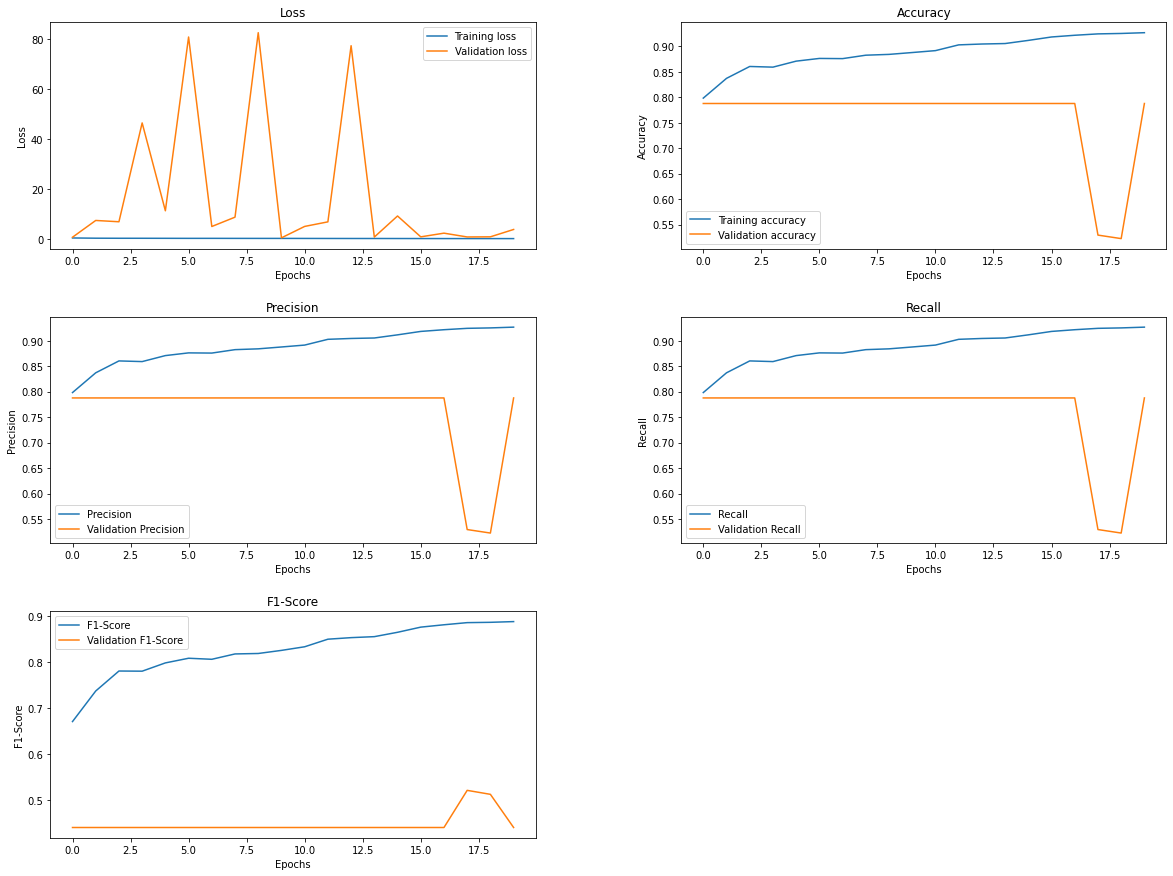

In [ ]:
plot_history(history)

<h1>Making the Xception model</h1>

In [ ]:
xception_model=TwoPathModel.two_path_xception()

In [ ]:
xception_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 224, 224, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 model (Functional)             (None, 256)          698560      ['input_1[0][0]']          

<h1>Training the model for 20 epochs at lr=1e-4</h1>

In [ ]:
xception_model.compile(loss="categorical_crossentropy",
                  optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=[keras.metrics.CategoricalAccuracy(),keras.metrics.Precision(),keras.metrics.Recall(),tfa.metrics.F1Score(num_classes=2)])

In [ ]:
history=xception_model.fit(train_generator,epochs=20,validation_data=valid_generator)

Epoch 1/20
335/335 [==============================] - 312s 836ms/step - loss: 0.3397 - categorical_accuracy: 0.8540 - precision: 0.8540 - recall: 0.8540 - f1_score: 0.7722 - val_loss: 0.5811 - val_categorical_accuracy: 0.7876 - val_precision: 0.7876 - val_recall: 0.7876 - val_f1_score: 0.4406
Epoch 2/20
335/335 [==============================] - 274s 816ms/step - loss: 0.2049 - categorical_accuracy: 0.9109 - precision: 0.9109 - recall: 0.9109 - f1_score: 0.8643 - val_loss: 3.0883 - val_categorical_accuracy: 0.7877 - val_precision: 0.7877 - val_recall: 0.7877 - val_f1_score: 0.4406
Epoch 3/20
335/335 [==============================] - 272s 811ms/step - loss: 0.1602 - categorical_accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - f1_score: 0.9020 - val_loss: 135.6946 - val_categorical_accuracy: 0.7877 - val_precision: 0.7877 - val_recall: 0.7877 - val_f1_score: 0.4406
Epoch 4/20
335/335 [==============================] - 273s 816ms/step - loss: 0.1443 - categorical_accuracy: 0.9438 

In [ ]:
xception_model.save_weights("two_path_xception.h5")

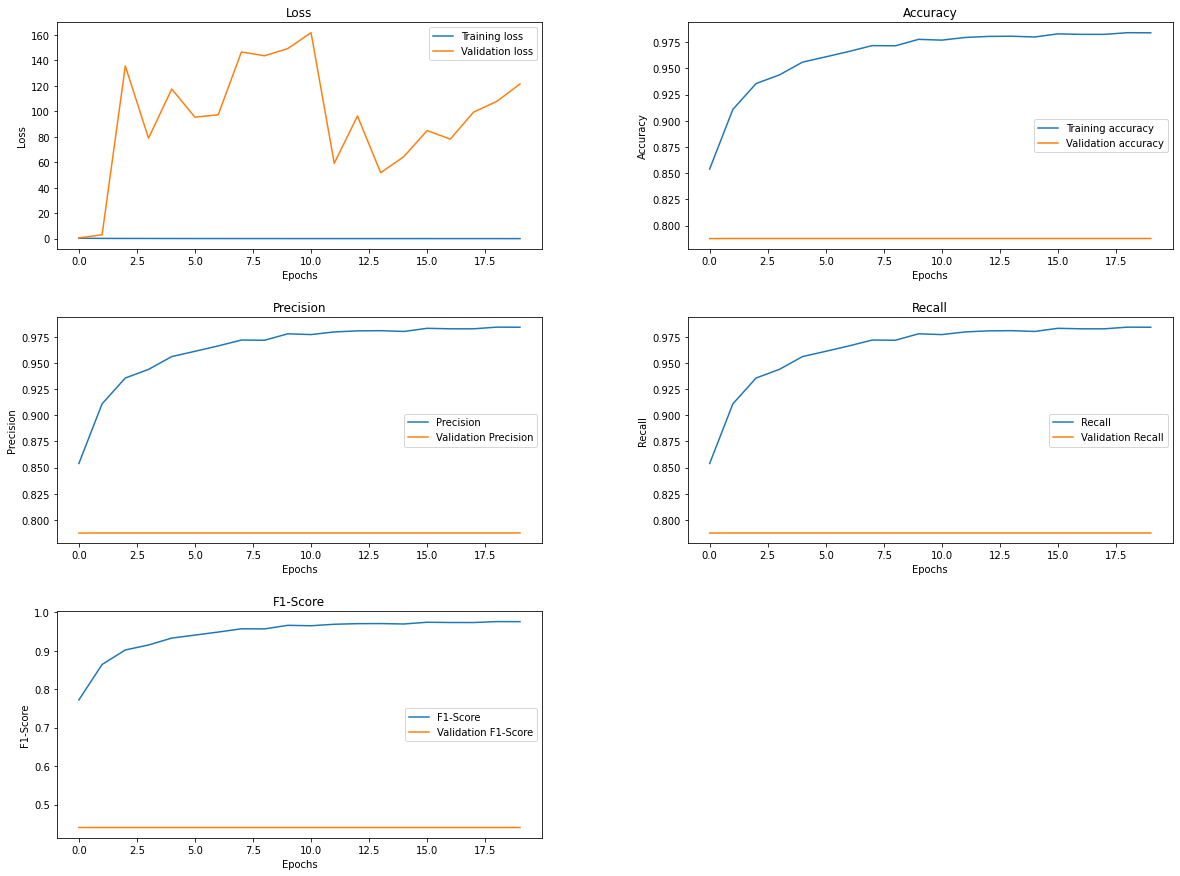

In [ ]:
plot_history(history)